In [6]:
import datetime
import numpy as np
from matplotlib import pyplot as plt, dates
import seaborn as sns 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

In [12]:
data = pd.read_csv('albedo_df_updated.csv')
data = data.drop('AL2', axis=1)

x_data = data.drop('albedo', axis=1)
for ind in range(0,len(x_data.columns),1):
    fea = x_data.columns[ind]
    print(f"feature-name = {fea}, max = {max(x_data[fea])}, min = {min(x_data[fea])}")

eig_valuess [5.27482653e+03 1.66559183e+03 1.27143225e+03 4.63844220e+02
 1.35889028e+02 5.72773668e+01 7.70168637e+00 4.76277758e+00
 3.92073935e+00 2.95960611e+00 8.48230522e-01 5.75730283e-01
 7.54565771e-02 2.03202922e-02 1.53282146e-02]

-----------------------------

eig_vectors [[ 1.88342892e-01  1.45619188e-01 -7.60712945e-03  6.66737325e-01
  -6.81756820e-01  1.80366373e-01  6.38856100e-03  1.94045373e-02
  -4.74259772e-03 -1.99340754e-04 -1.28418974e-02  2.63389495e-02
   3.30965083e-03 -8.74374004e-03 -3.89155175e-03]
 [-3.48606438e-03  1.12615522e-02 -2.14282677e-03  2.56882134e-02
  -1.99619981e-02 -4.19676685e-02  2.73687110e-02 -6.51620781e-03
   1.79793509e-02 -3.37972955e-01  1.19448524e-01 -9.03619824e-01
   2.21622629e-01 -3.92725344e-02 -1.55126472e-02]
 [-8.53313296e-02  1.49121733e-01 -1.72973559e-01  3.13192978e-01
   8.08481693e-02 -8.88797106e-01  3.50380170e-02  6.80711749e-03
   4.30664203e-02  2.05546149e-01 -1.73600781e-03 -2.16246284e-02
   9.57158911e-03 

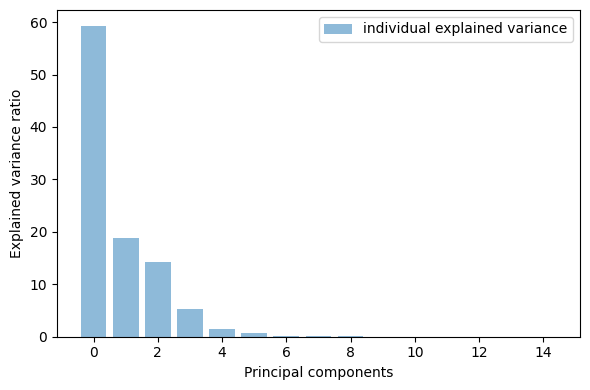

In [3]:
# feature selection 

x_data_ub = x_data - x_data.mean()
cov_data = x_data_ub.cov()
eigenvalues, eigenvectors = np.linalg.eig(cov_data)
print("eig_valuess", eigenvalues)
print("\n-----------------------------\n")
print("eig_vectors", eigenvectors)

# how many features?
explained_variance = []
for eigenvalue in eigenvalues:
    explained_variance.append((eigenvalue / sum(eigenvalues)) * 100)
print(explained_variance)

with plt.style.context('ggplot'):
    plt.figure(figsize=(6, 4))
plt.bar(range(15), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend()
plt.tight_layout()

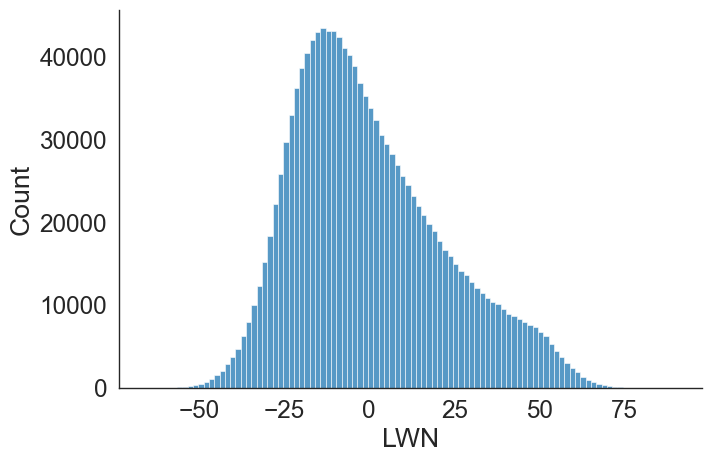

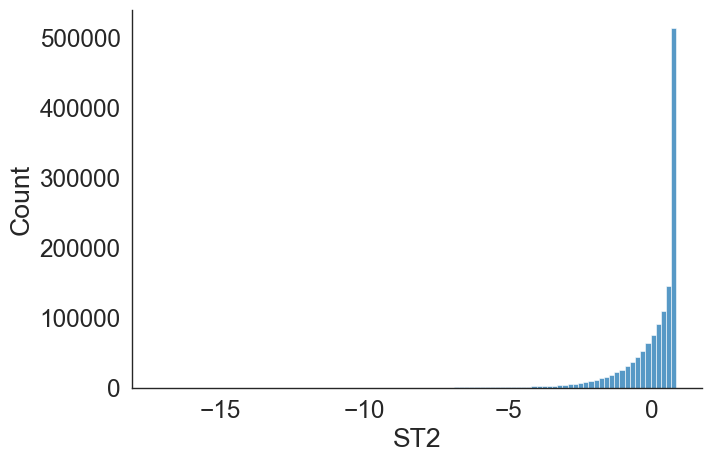

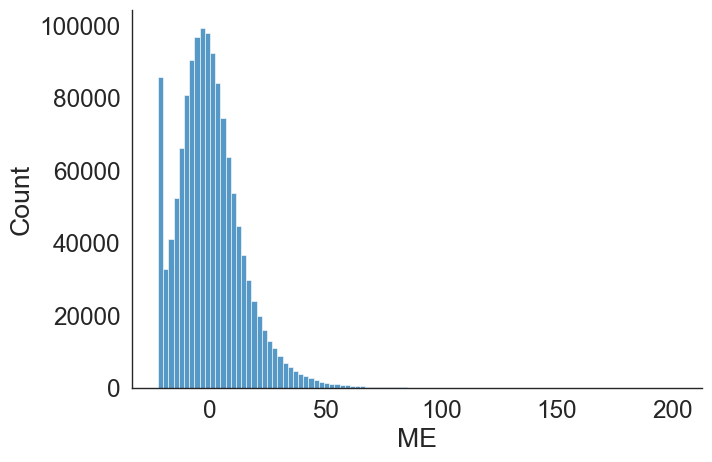

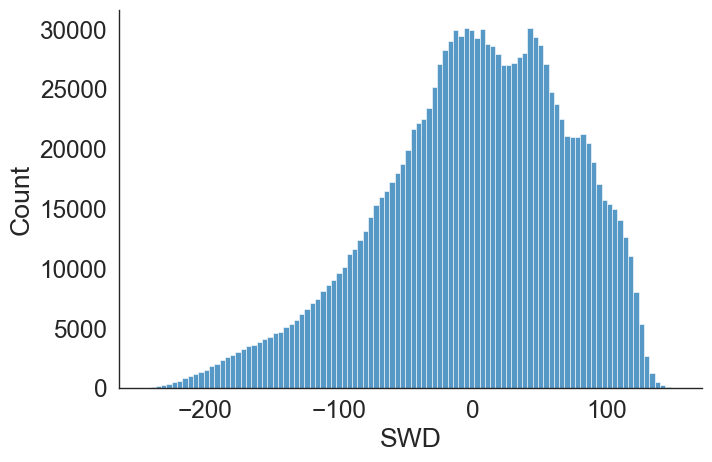

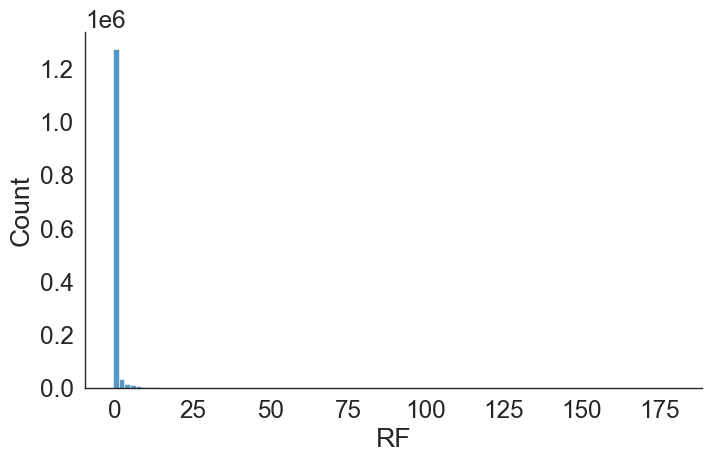

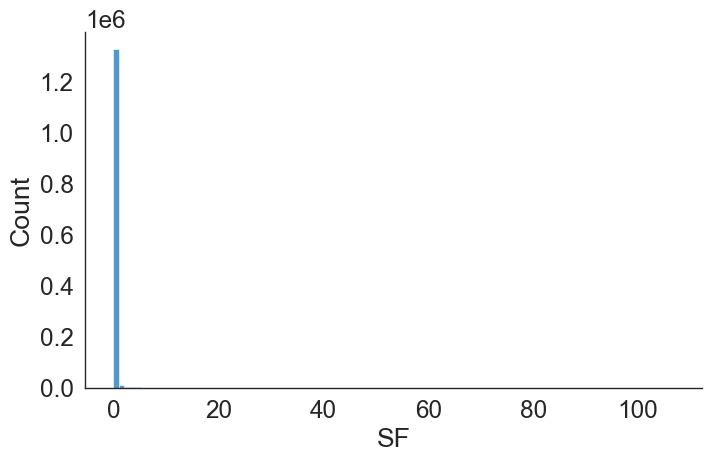

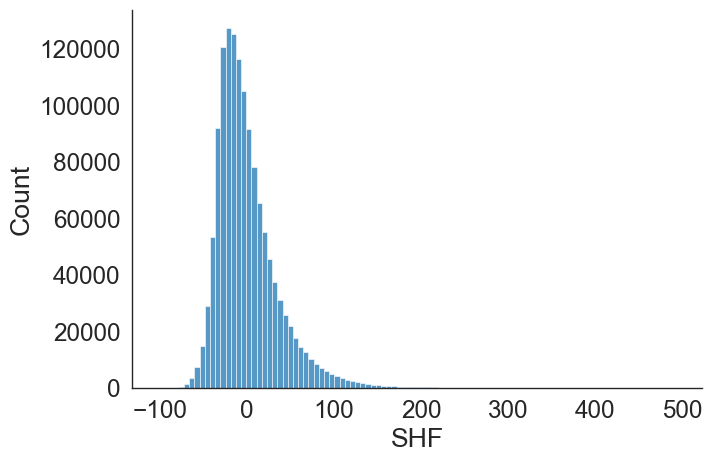

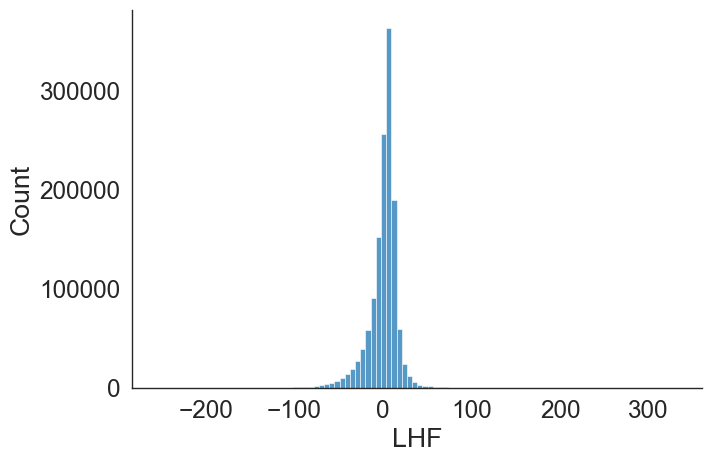

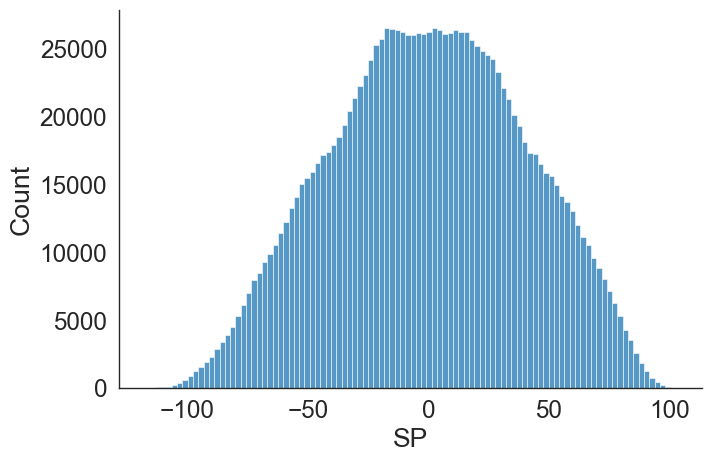

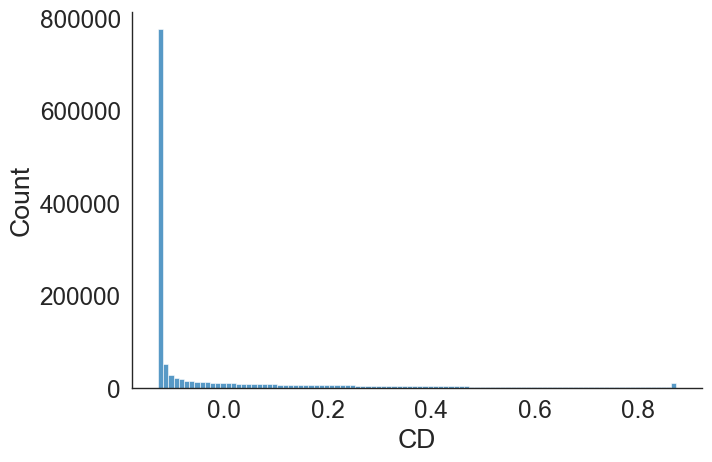

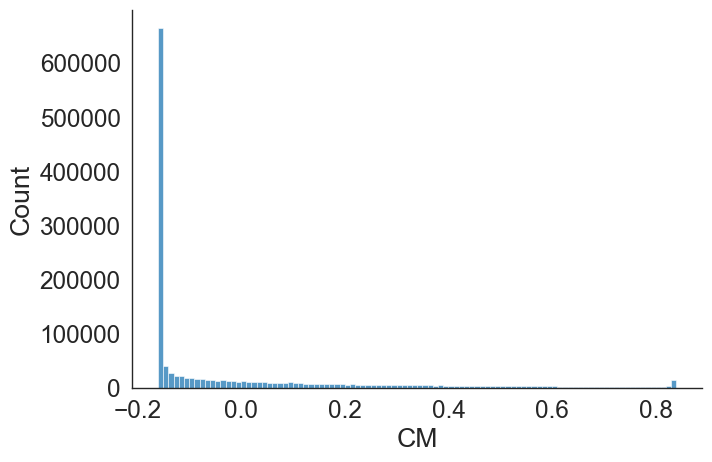

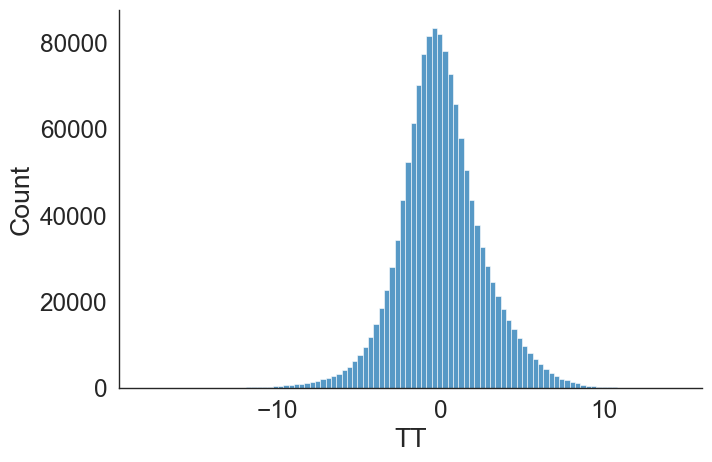

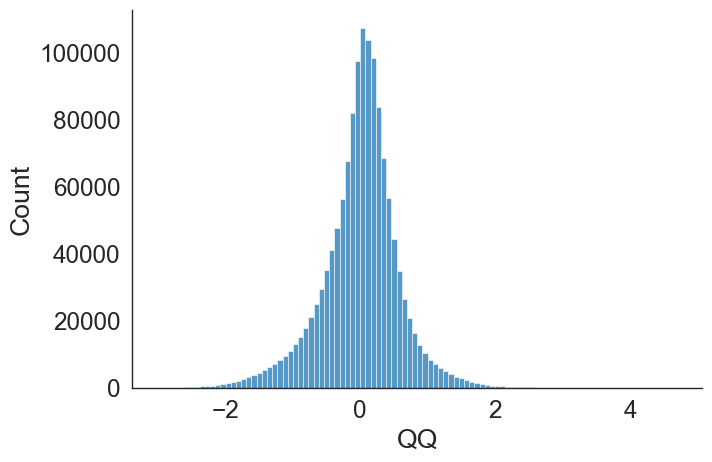

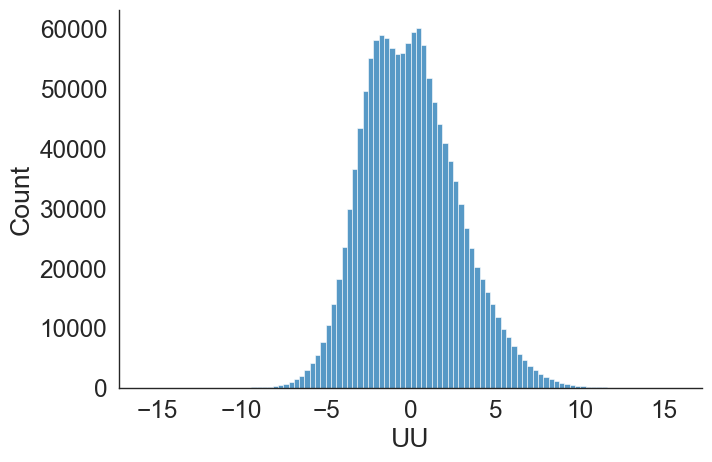

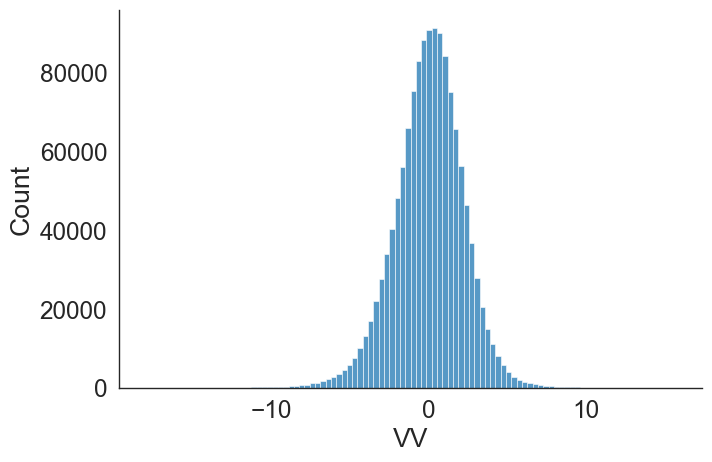

In [11]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
for i in range(0,len(x_data.columns),1):
    sns.displot(data = x_data_ub, x = x_data.columns[i], kind = "hist", bins = 100, aspect = 1.5)

In [4]:
y = np.array(data['albedo'])
x = x_data_ub.drop(['ST2','RF','SF','CD','CM'], axis = 1)
print(x.shape)

(1356346, 10)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
rf1 = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf1.fit(x_train, y_train)

y_pred = rf1.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R^2 =", r2)

R^2 = 0.38950354577340884


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
rf2 = RandomForestRegressor(n_estimators = 200,
                            min_samples_split = 5,
                            min_samples_leaf = 2,
                            max_features = 'sqrt',
                            max_depth = 52,
                            bootstrap = False,
                            random_state = 42)

rf2.fit(x_train, y_train)

y_pred = rf2.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R^2 =", r2)

R^2 = 0.40215535614303133


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
rf3 = RandomForestRegressor(n_estimators = 200, random_state = 42)

rf3.fit(x_train, y_train)

y_pred = rf3.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R^2 =", r2)

R^2 = 0.39318654099590433


In [2]:
# Anomaly Detection

import numpy as np
import scipy.io
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

data = pd.read_csv('albedo_df_updated.csv')
data = data.drop('AL2', axis=1)
x_data = data.drop('albedo', axis=1)

scaler = StandardScaler()
x = scaler.fit_transform(x_data)
y = np.array(data['albedo']) / 100

print('Anomaly Detection:')
iso = IsolationForest(contamination=0.1)
y_out = iso.fit_predict(x)

# select all rows that are not outliers
mask = y_out != -1
x_outs, y_outs = x[mask, :], y[mask]
print(x_outs.shape, y_outs.shape)

Anomaly Detection:
(1220711, 15) (1220711,)


In [4]:
# RF After Anomaly Detection 

from sklearn.ensemble import RandomForestRegressor

x_train, x_test, y_train, y_test = train_test_split(x_outs, y_outs, test_size = 0.2, random_state = 42)
rf_allin = RandomForestRegressor(n_estimators = 200,
                            min_samples_split = 5,
                            min_samples_leaf = 2,
                            max_features = 'sqrt',
                            max_depth = 52,
                            bootstrap = False,
                            random_state = 42)

rf_allin.fit(x_train, y_train)

y_pred = rf_allin.predict(x_test)
r2 = r2_score(y_test, y_pred)
print("R^2 =", r2)

R^2 = 0.37874166287746136


In [ ]:
# LSTM

import datetime
import numpy as np
import scipy.io
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.initializers import glorot_uniform, random_uniform, RandomNormal

data = pd.read_csv('albedo_df_updated.csv')
data = data.drop('AL2', axis=1)

x_data = data.drop('albedo', axis=1)

scaler = StandardScaler()
x = scaler.fit_transform(x_data)

# x = np.array(x_data)
y = np.array(data['albedo']) / 100
print("original:", x.shape, y.shape)


def data_sqlization(x, y, time_step):

    n = 0
    x_seq = []

    while n < x.shape[0]-time_step:
        x_seg = x[n:n+time_step]
        x_seq.append(x_seg)
        n += 1

    x_seq = np.array(x_seq)
    x_seq.reshape(x.shape[0]-time_step, time_step, x.shape[1])
    y_seq = y[time_step:]

    return x_seq, y_seq


x_seq, y_seq = data_sqlization(x=x, y=y, time_step=30)
print("after sqlization:", x_seq.shape, y_seq.shape)

x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size = 0.2, random_state = 42)


# initializer = RandomNormal(mean=0., stddev=1.)
lstm = Sequential(
    [
        LSTM(32, input_shape=(x_train.shape[1],x_train.shape[-1])),
        Activation('relu'),
        Dense(20),
        Activation('relu'),
        Dropout(0.2),
        Dense(1)
        # Activation('relu')
    ]
)

lstm.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError'])
lstm.fit(x_train, y_train, batch_size=500, epochs=100)

y_train_pred = lstm.predict(x_train)
print("train R^2 =", r2_score(y_train, y_train_pred))
y_test_pred = lstm.predict(x_test)
print("test R^2 =", r2_score(y_test, y_test_pred))

In [ ]:
# LSTM2

import datetime
import numpy as np
import scipy.io
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, LSTMCell, RNN, Embedding
from keras.initializers import glorot_uniform, random_uniform

data = pd.read_csv('albedo_df_updated.csv')
data = data.drop('AL2', axis=1)

x_data = data.drop('albedo', axis=1)

scaler = StandardScaler()
x = scaler.fit_transform(x_data)

# x = np.array(x_data)
y = np.array(data['albedo']) / 100
print("original:", x.shape, y.shape)


def data_sqlization(x, y, time_step):

    n = 0
    x_seq = []

    while n < x.shape[0]-time_step:
        x_seg = x[n:n+time_step]
        x_seq.append(x_seg)
        n += 1

    x_seq = np.array(x_seq)
    x_seq.reshape(x.shape[0]-time_step, time_step, x.shape[1])
    y_seq = y[time_step:]

    return x_seq, y_seq


x_seq, y_seq = data_sqlization(x=x, y=y, time_step=15)
print("after sqlization:", x_seq.shape, y_seq.shape)

x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size = 0.2, random_state = 42)


cells = [LSTMCell(64,kernel_initializer=glorot_uniform(),dropout=0.2), 
         LSTMCell(32,kernel_initializer=glorot_uniform(),dropout=0.2)]
lstm2 = Sequential(
    [
        RNN(cells),
        Dense(20),
        Activation('relu'),
        Dropout(0.2),
        Dense(1)
    ]
)


lstm2.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError'])
lstm2.fit(x_train, y_train, batch_size=500, epochs=100)

y_train_pred = lstm2.predict(x_train)
print("train R^2 =", r2_score(y_train, y_train_pred))
y_test_pred = lstm2.predict(x_test)
print("test R^2 =", r2_score(y_test, y_test_pred))